### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib.pylab as plb
import pandas as pd

import pickle
import re

In [2]:
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, \
mean_squared_error, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

In [3]:
import warnings
warnings.filterwarnings('ignore')

### NLP and more cleaning specific to Q1

In [4]:
df = pd.read_pickle("./allcleaned.pkl")

In [5]:
df.shape

(2945, 17)

In [6]:
# the first thing we need to do is get rid of rows without salaries for Q1
df[df.avgsalary==0].avgsalary.count()

2113

In [7]:
df.drop(df[df.avgsalary==0].index, axis=0, inplace=True)

In [8]:
df.dropna(axis=0, subset=['avgsalary'], inplace=True)

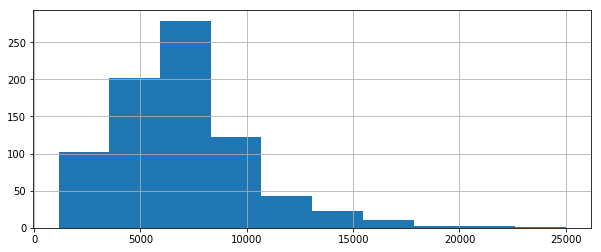

In [9]:
df.avgsalary.hist(figsize=(10,4), bins=10)

In [10]:
# there is a significant right skew in the salary. however, since this problem will be tackled
# as a classification problem using the quartile system as a divider, this should not pose a problem

In [11]:
df.avgsalary.describe()

count      787.000000
mean      6892.115488
std       3193.367428
min       1150.000000
25%       4750.000000
50%       6500.000000
75%       8500.000000
max      25000.000000
Name: avgsalary, dtype: float64

run vectorizer on jd first.

In [12]:
# it's one giant string. cool.
df.jd[51]

'Roles & ResponsibilitiesPalo IT is an innovation & agile development company. From Design Research to DevOps, we are in the business of end-to-end development of breakthrough digital experiences. As a community of innovators and developers, we also aim at renewing the way organizations operate, promoting sustainable business agility, user-centricity and open collaboration while having fun doing it.  Started in Paris in 2009 and with offices in Singapore, Hong Kong and Mexico, we are looking for our next superstar to join our exciting team in Singapore.  At Palo IT, our employees are not widgets. They are in the center of all our projects and successes. We offer an exciting and creative working environment, with endless opportunities to develop your skills, travel and take your career to the next level. Get in touch to find out more!  Your profile & role on the project  YOU:  \uf0a7 Thrive on challenge. When was the last time you fail?  \uf0a7 Are curious & always learning. What are yo

In [13]:
def cleanrd1(text):
    text = text.lower()
    # removes carriage returns
    text = re.sub('/(\r\n)+|\r+|\n+|\t+/i', ' ', text)
    # remove everything NOT in the brackets (with caret)
    text = re.sub(r"[^a-zA-Z ]"," ",text)
    return text

clean1 = lambda x: cleanrd1(x)
# df['text'] = df['jd'].apply(clean1)

In [14]:
df['text'] = df.jd.apply(clean1)

In [15]:
# save to pickle first
df.to_pickle('./Q1textcleaned.pkl')

In [16]:
df.text[51]

'roles   responsibilitiespalo it is an innovation   agile development company  from design research to devops  we are in the business of end to end development of breakthrough digital experiences  as a community of innovators and developers  we also aim at renewing the way organizations operate  promoting sustainable business agility  user centricity and open collaboration while having fun doing it   started in paris in      and with offices in singapore  hong kong and mexico  we are looking for our next superstar to join our exciting team in singapore   at palo it  our employees are not widgets  they are in the center of all our projects and successes  we offer an exciting and creative working environment  with endless opportunities to develop your skills  travel and take your career to the next level  get in touch to find out more   your profile   role on the project  you     thrive on challenge  when was the last time you fail     are curious   always learning  what are you up to ri

In [17]:
corpus = [t for t in df.text]

In [18]:
from nltk.corpus import stopwords
# import stopwords with option of adding more customized ones later 
stop = stopwords.words('english')

In [19]:
# get stem words 
# tried porter stemmer but results were not encouraging so dropped. 

# from nltk.stem import PorterStemmer
# wordlist=[]
# newcorpus = []
# porter=PorterStemmer()

# for c in corpus[:2]:
#     wordblock = word_tokenize(c)
#     for word in wordblock:
#         wordlist.append(porter.stem(word))
#         print(wordlist) 
#     newcorpus.append(' '.join(wordlist))



In [20]:
tvec = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), max_df=0.9, max_features=20000)

In [21]:
# builds vocab using fit and transforms words into numbers w transform
tvec.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=20000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
X = tvec.transform(corpus)

In [23]:
Xt = pd.DataFrame(X.todense(), 
                    columns=tvec.get_feature_names(), index = df.index)

In [24]:
Xt.shape

(787, 20000)

In [25]:
Xt.sum().sort_values(ascending=False).head(20)

data                48.851408
business            30.593406
work                19.315761
team                19.308395
learning            19.094187
skills              18.451462
management          18.248221
knowledge           16.305759
requirements        15.934647
development         15.647948
database            15.120600
project             15.104364
analytics           14.754764
design              14.699191
solutions           14.657584
support             14.394671
machine             14.087927
working             13.620862
strong              13.592033
machine learning    13.565335
dtype: float64

In [26]:
df.columns

Index(['advertiser', 'avgsalary', 'district', 'elapsed', 'industry', 'jd',
       'jobtitle', 'jobtype', 'portal', 'searchstring', 'seniority', 'source',
       'employees', 'firmsize', 'function', 'rank', 'level', 'text'],
      dtype='object')

In [27]:
#df.rank pulls up function, so rename to avoid clash
df.rename(columns={'rank': 'ranked'}, inplace=True)

In [28]:
df.elapsed = pd.to_numeric(df.elapsed)

In [29]:
# check for nulls
df.isnull().sum()

advertiser        0
avgsalary         0
district        184
elapsed           0
industry         41
jd                0
jobtitle          0
jobtype          29
portal            0
searchstring      0
seniority        41
source            0
employees         1
firmsize          0
function         41
ranked           41
level            41
text              0
dtype: int64

In [30]:
# impute median rank to null ranked rows as this is numerical and will cause problems in modelling
# later if not handled
np.median(~df.ranked.isnull())

1.0

In [31]:
df.ranked.fillna(np.median(~df.ranked.isnull()), inplace=True)

In [32]:
# for others, replace with 'None' as these are categoricals
todrop = ['district','industry', 'jobtype']
for t in todrop:
    df[t].fillna('None',  inplace=True)

In [33]:
# create final dataframe for classification exercise 

In [34]:
X = df.select_dtypes(include='number')
X.head()

,avgsalary,elapsed,employees,firmsize,function,ranked,level
0,9000.0,0.0,20000.0,3,0.0,3.0,3.0
1,5100.0,0.0,1.0,0,2.0,2.0,0.0
2,17500.0,0.0,1.0,0,3.0,3.0,0.0
3,10500.0,0.0,1.0,0,4.0,8.0,4.0
4,8500.0,0.0,1.0,0,2.0,7.0,5.0


In [35]:
X = X.drop(['avgsalary', 'function','level','employees'], axis=1)
X.shape

(787, 3)

In [36]:
# some jobs belong to multiple industries, so let's split the industry variable
dummy = df.industry.str.strip().str.get_dummies(sep=',')
#industry_split = df.industry.str.strip().str.split(',', expand=True).stack()

In [37]:
dummy.shape

(787, 63)

In [38]:
X = pd.concat([X, dummy], axis=1)
X.shape

(787, 66)

In [39]:
# columns to convert into dummy variables 
dummies = ['district', 'jobtype', 'portal', 'searchstring']

In [40]:
dummy = pd.get_dummies(df[dummies], prefix=dummies, drop_first=True)
X = pd.concat([X, dummy], axis=1)
X.shape

(787, 104)

In [41]:
# check for NAs
X.columns[X.isnull().any()]

Index([], dtype='object')

In [42]:
# prefix jd word columns with 'jd' for ID purposes
Xt.columns = 'jd_' + Xt.columns
Xt.shape

(787, 20000)

In [43]:
X = pd.concat([X, Xt], axis=1)

In [44]:
X.shape

(787, 20104)

In [45]:
# let y fall into 2 salary buckets, corresp to below and above the median
df['salbucket'] = np.where(df.avgsalary>=df.avgsalary.quantile(.5), 1, 0)

In [46]:
y = df.salbucket

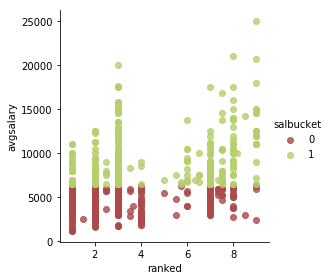

In [47]:
sns.lmplot(x = 'ranked', y = 'avgsalary', data = df, hue = 'salbucket', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
plt.show()

In [48]:
df.to_pickle('./Q1premodeltfidf.pkl')

### MODELLING

In [56]:
# what is our baseline y?
# we chose 50-50
# therefore baseline = 0.5
baseline = 0.5

In [57]:
# split dataset into train and test set
ss= StandardScaler()
X_train, X_test, y_train, y_test = \
           train_test_split(X, y, \
                            random_state = 140, test_size = 0.2, stratify=y)
# scale data fit and transform train set but just transform test set
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

<div class="alert alert-warning">
    1. Logistic Regression + GridSearchCV

In [78]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters and perform
# cross-validation at the same time.

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(0,4,20) #np.linspace(1, 25, 25)
}

In [262]:
logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, cv=5, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.7min finished


In [263]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)

Best mean cross-validated score achieved: 0.699523052464229
Best parameters: {'C': 4.281332398719393, 'penalty': 'l2', 'solver': 'liblinear'}


In [264]:
logrbest = logr_result.best_estimator_
# this is the accuracy score ie. tp+tn/totpopn
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Logistic Regression Classification score: 0.6455696202531646
Baseline: 0.5


In [265]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[50, 29],
       [27, 52]], dtype=int64)

In [266]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64        79
           1       0.64      0.66      0.65        79

   micro avg       0.65      0.65      0.65       158
   macro avg       0.65      0.65      0.65       158
weighted avg       0.65      0.65      0.65       158



In [267]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.6455696202531646


In [268]:
# get coefficients
lrcoef = pd.DataFrame(logrbest.coef_.T, index=Xs_test.columns, columns=['coef'])
lrcoef['abscoef'] = abs(lrcoef.coef)
lrcoef.sort_values(by='abscoef', ascending=False).head(20)

,coef,abscoef
searchstring_Data Engineer,-0.939198,0.939198
elapsed,-0.676352,0.676352
jd_employment type,-0.448772,0.448772
jd_role business,-0.332689,0.332689
ranked,0.329132,0.329132
jd_role senior,0.328359,0.328359
jd_users well,0.319291,0.319291
jd_engineer work,-0.315624,0.315624
jd_finance marketing,-0.228211,0.228211
jd_responsibilitiesas data,-0.192736,0.192736


In [269]:
# Run #1 currently #1 in terms of AUC score

<div class="alert alert-warning">
    4. Random Forest Classifier + GridSearchCV

In [58]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, cv=5, verbose=1)
ranf_result = ranf_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  7.0min finished


In [59]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

Best mean cross-validated score achieved: 0.7106518282988871
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}


In [60]:
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Random Forest Classification score: 0.6835443037974683
Baseline: 0.5


In [61]:
confusion_matrix(y_test, ranfbest.predict(Xs_test))

array([[54, 25],
       [25, 54]], dtype=int64)

In [62]:
print(classification_report(y_test, ranfbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        79
           1       0.68      0.68      0.68        79

   micro avg       0.68      0.68      0.68       158
   macro avg       0.68      0.68      0.68       158
weighted avg       0.68      0.68      0.68       158



In [63]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.6835443037974683


In [64]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = ranfbest.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree2.dot', feature_names = X_test.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree2.dot')
# Write graph to a png file
graph.write_png('tree2.png')


In [65]:
# Get numerical feature importances
importances = list(ranfbest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, \
                       importance in zip(X_test.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# drop those with importance <=0
#[feature_importances.remove(pair) for pair in feature_importances if pair[1]<=0]
# Print out the feature and importances 
['Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances[:20]]

['Variable: ranked               Importance: 0.0083',
 'Variable: jd_diploma           Importance: 0.0062',
 'Variable: jd_degree            Importance: 0.0059',
 'Variable: jd_preparation       Importance: 0.0058',
 'Variable: jd_conduct           Importance: 0.0055',
 'Variable: jd_understanding     Importance: 0.0053',
 'Variable: jd_business          Importance: 0.0052',
 'Variable: jd_system            Importance: 0.0051',
 'Variable: jd_duties            Importance: 0.005',
 'Variable: jd_complex           Importance: 0.0049',
 'Variable: jd_hands             Importance: 0.0047',
 'Variable: jd_functional        Importance: 0.0046',
 'Variable: jd_monthly           Importance: 0.0045',
 'Variable: jd_architecture      Importance: 0.0044',
 'Variable: jd_banking           Importance: 0.0043',
 'Variable: jd_excel             Importance: 0.0042',
 'Variable: jd_hoc               Importance: 0.0042',
 'Variable: jd_proven            Importance: 0.004',
 'Variable: jd_technology     

In [66]:
# Run #4 currently #1 in terms of AUC score

<div class="alert alert-warning">
    5. Random Forest Classifier + GridSearchCV with top 20 features from #4. 

In [67]:
# let's try a new random forest using only the top 20 features and see how it fares 
notranftopfeatures = [x[0] for x in feature_importances[20:]]

In [68]:
# reducing columns in X test and train sets
Xs_train.drop(columns=notranftopfeatures, inplace=True)
Xs_test.drop(columns=notranftopfeatures, inplace=True)

In [69]:
Xs_train.shape

(629, 20)

In [70]:
Xs_test.columns

Index(['ranked', 'jd_architecture', 'jd_banking', 'jd_business', 'jd_complex',
       'jd_conduct', 'jd_degree', 'jd_diploma', 'jd_diploma degree',
       'jd_duties', 'jd_excel', 'jd_functional', 'jd_hands', 'jd_hoc',
       'jd_monthly', 'jd_preparation', 'jd_proven', 'jd_system',
       'jd_technology', 'jd_understanding'],
      dtype='object')

In [71]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, cv=5, verbose=1)
ranf_result = ranf_gridsearcher.fit(Xs_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.8min finished


In [72]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

Best mean cross-validated score achieved: 0.7329093799682035
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}


In [73]:
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Random Forest Classification score: 0.6962025316455697
Baseline: 0.5


In [74]:
# Get numerical feature importances
importances = list(ranfbest.feature_importances_)
# get coefficients
rfcoef = pd.DataFrame(importances, index=Xs_test.columns, columns=['rfcoef'])
rfcoef.sort_values(by='rfcoef', ascending=False)

,rfcoef
ranked,0.121998
jd_business,0.081527
jd_functional,0.073046
jd_system,0.068299
jd_degree,0.067306
jd_architecture,0.059210
jd_understanding,0.057347
jd_diploma,0.056706
jd_complex,0.050866
jd_excel,0.047872


In [75]:
# Run #5 currently #1 in terms of AUC score

<div class="alert alert-warning">
    6. Logistic Regression + GridSearchCV with top 20 features from #4. 

In [76]:
# generic function for GridSearchCV method for classification probs
def gscv(method, prefix, cv, Xtrain, ytrain, Xtest, ytest):

    gridsearcher = GridSearchCV(method, param_grid=prefix,cv=cv, verbose=1)
    result = gridsearcher.fit(Xtrain, ytrain)

    #print('Best mean cross-validated score achieved:', result.best_score_)
    print('Best parameters:', result.best_params_)
    # this is the accuracy score ie. tp+tn/totpopn
    best = result.best_estimator_
    print('Logistic Regression Classification score:', best.score(Xtest, ytest))
    print('Baseline:', baseline)
    # confusion matrix
    print(confusion_matrix(ytest, best.predict(Xtest)))
    # classification report
    print(classification_report(ytest, best.predict(Xtest)))
    # get AUC / ROC
    fpr, tpr, _ = roc_curve(ytest, best.predict(Xtest))
    roc_auc = auc(fpr, tpr)
    print('Logistic Regression Classification AUC:', roc_auc)
    return best

In [79]:
logr = gscv(LogisticRegression(), logr_parameters, 5, Xs_train, y_train, Xs_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'C': 1.6237767391887217, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.7088607594936709
Baseline: 0.5
[[55 24]
 [22 57]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.71        79
           1       0.70      0.72      0.71        79

   micro avg       0.71      0.71      0.71       158
   macro avg       0.71      0.71      0.71       158
weighted avg       0.71      0.71      0.71       158

Logistic Regression Classification AUC: 0.7088607594936707


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


In [80]:
# Run #6 currently #1 in terms of AUC score 

In [81]:
# get coefficients
lrcoef = pd.DataFrame(logr.coef_.T, index=Xs_test.columns, columns=['lrcoef'])
lrcoef['lrabscoef'] = abs(lrcoef.lrcoef)
lrcoef.sort_values(by='lrabscoef', ascending=False)

,lrcoef,lrabscoef
jd_monthly,-0.388997,0.388997
jd_excel,-0.370307,0.370307
ranked,0.356788,0.356788
jd_functional,0.340240,0.340240
jd_system,-0.336147,0.336147
jd_duties,-0.309782,0.309782
jd_diploma,-0.296960,0.296960
jd_banking,0.283174,0.283174
jd_diploma degree,-0.269874,0.269874
jd_conduct,-0.258129,0.258129


In [82]:
#let's combine this list of coefficients from run #6 with run #5

In [83]:
coefdf = pd.merge(lrcoef, rfcoef, how='inner', left_index=True, right_index=True)

In [90]:
# let's get the avg rank of the coefs based on logistic regression and random forest methods
# and sort them to find the top factors

coefdf["lrrank"] = coefdf["lrabscoef"].rank(ascending=False)
coefdf["rfrank"] = coefdf["rfcoef"].rank(ascending=False)
coefdf['avgrank'] = (coefdf.lrrank+coefdf.rfrank)/2
coefdf.sort_values(by='avgrank')[:10]

,lrcoef,lrabscoef,rfcoef,lrrank,rfrank,avgrank
ranked,0.356788,0.356788,0.121998,3.0,1.0,2.0
jd_functional,0.340240,0.340240,0.073046,4.0,3.0,3.5
jd_system,-0.336147,0.336147,0.068299,5.0,4.0,4.5
jd_excel,-0.370307,0.370307,0.047872,2.0,10.0,6.0
jd_diploma,-0.296960,0.296960,0.056706,7.0,8.0,7.5
jd_banking,0.283174,0.283174,0.044057,8.0,11.0,9.5
jd_business,0.125103,0.125103,0.081527,17.0,2.0,9.5
jd_architecture,0.189622,0.189622,0.059210,14.0,6.0,10.0
jd_monthly,-0.388997,0.388997,0.024131,1.0,19.0,10.0
jd_duties,-0.309782,0.309782,0.027551,6.0,17.0,11.5


In [49]:
X.filter(like='system').sum().sort_values(ascending=False)[:10]

jd_systems                  11.561359
jd_system                   11.019558
jd_information systems       1.811293
jd_ecosystem                 1.668286
jd_operating systems         0.917665
jd_database systems          0.870437
jd_operating system          0.865299
jd_information system        0.842363
jd_management systems        0.831581
jd_system administration     0.796104
dtype: float64

In [87]:
X.filter(like='excel').sum().sort_values(ascending=False)[:10]

jd_excellent                  8.086466
jd_excel                      4.563970
jd_excellent communication    2.644136
jd_skills excellent           1.918862
jd_excellence                 1.488932
jd_excellent verbal           1.341669
jd_ms excel                   1.189418
jd_excellent written          1.185064
jd_excellent interpersonal    1.168679
jd_microsoft excel            1.167406
dtype: float64

<div class="alert alert-warning">
    <b> CONCLUSION: </b>
    <ul><li>The results from using Tf-idf vs a normal countvectorizer slightly improved overall scores. 
<li>Runs #4-6 (random forest with all features) produce a slightly higher score, but run #1 is lower. 
<li>Certain top determinants of salary did not change much, like the seniority level and function of the position ie. the 'ranked' variable, and the 'functional', 'diploma', 'banking' and 'architecture' keywords.
<li>Words like 'monthly' and 'duties' seem to imply more menial work, as higher-paying jobs presumably don't need to mention monthly remuneration and replace 'duties' with 'goals' or 'responsibilities'
    <li> the words 'system' and 'excel' seem to be associated with administrative and qualitative functions respectively, and are negatively correlated to higher pay. interestingly, communication and interpersonal skills are almost always highly prized in other fields. 
</ul>
    

<div class="alert alert-warning">
    <b> BONUS QUESTION: </b>

In [97]:
confusion_matrix(y_test, ranfbest.predict(Xs_test))

array([[51, 28],
       [20, 59]], dtype=int64)

In [98]:
print(classification_report(y_test, ranfbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68        79
           1       0.68      0.75      0.71        79

   micro avg       0.70      0.70      0.70       158
   macro avg       0.70      0.70      0.70       158
weighted avg       0.70      0.70      0.70       158



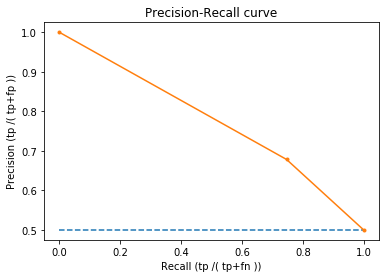

In [114]:
from sklearn.metrics import precision_recall_curve
precision, recall,_ = precision_recall_curve(y_test, ranfbest.predict(Xs_test))
#auc = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plb.xlabel('Recall (tp /( tp+fn ))')
plb.ylabel('Precision (tp /( tp+fp ))')
# show the plot
plt.show()

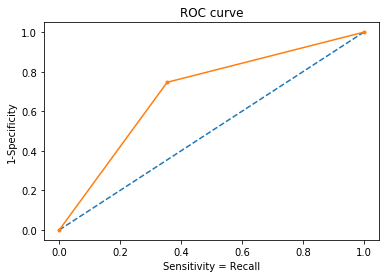

In [113]:

#fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC curve')
# labels
plb.xlabel('Sensitivity = Recall')
plb.ylabel('1-Specificity')
# show the plot
plt.show()

<div class="alert alert-warning">
    <ul><li>if boss would rather be wrong about telling jobseeker salary is lower than actual rather than higher than actual, then the boss is more afraid of a false positive than false negative. 
        <li>that is, based on the confusion matrix, he would rather be bottom left than top right. 
    <li>Looking at the Precision-Recall curve below, there is an inverse relationship between fp and fn, so if you try to reduce fn, you may necessarily bump up fp as well.
        <li>Put another way (refer ROC curve) if false positives increase (y-axis), the rate of true positive predictions (x-axis) increases as well, which is a favourable outcome. 